In [1]:
from skimage import io
from skimage.measure import regionprops
from skimage.exposure import rescale_intensity
from skimage.color import label2rgb
from skimage.util import view_as_windows
from skimage.filters import rank, threshold_multiotsu
from skimage.segmentation import slic
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_distances
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from tqdm import tqdm
from pathlib import Path
from glob import glob
from os import path
import os
import random
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset

In [11]:
class FolderImageDataset(Dataset):
    def __init__(self, image_folder, ext='.png'):
        self.img_list = glob(path.join(image_folder, '*.'+ext))
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        pos = [int(s) for s in Path(self.img_list[idx]).stem.split('_') if s.isdigit()]
        img_path = self.img_list[idx]
        image = io.imread(img_path)
        if self.transform:
            image = self.transform(image)
        return image, pos

In [12]:
def compute_slide_reps(model, slide_path, ext='png', batch_size=64, save_matrix=True):
    with torch.no_grad():
        device = next(model.parameters()).device
        feat_list = []
        pos_list = []
        slide_dataset = FolderImageDataset(slide_path, ext)
        slide_dataloder = DataLoader(slide_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
        for idx, batch in enumerate(tqdm(slide_dataloder)):
            patch_tensor, pos = batch
            pos = [x.cpu().numpy() for x in pos]
            pos_list.extend(np.vstack(pos).transpose(1, 0))
            patch_tensor = patch_tensor.float()
            patch_tensor = patch_tensor.to(device)
            feats_tensor = model(patch_tensor)
            feat_list.extend(feats_tensor.cpu().numpy())
        feat_arr = np.vstack(feat_list)
        pos_arr = np.vstack(pos_list)
        if save_matrix:
            x_max, y_max = np.max(pos_arr, 0)+1
            canvas = np.zeros((y_max, x_max, feat_size))
            for idx in range(pos_arr.shape[0]):
                pos = pos_arr[idx]
                canvas[pos[1], pos[0]] = feat_arr[idx]
            io.imsave(path.join(slide_path.rstrip(os.sep)+'.tiff'), canvas.transpose(2, 0, 1))
        else:
            return feat_arr, pos_arr

In [13]:
def sample_pool_reps(slide_list, sample_frac=0.2):
    ### generate a list of patch reps from a list of slides(rep)
    sampled_reps = []
    for slide in slide_list:
        rep_arr = io.imread(slide)
        rep_arr_flat = rep_arr.reshape(feat_size, -1).transpose(1, 0)
        indices = np.random.choice(rep_arr_flat.shape[0], int(sample_frac*rep_arr_flat.shape[0]), replace=False)
        sampled = rep_arr_flat[indices]
        sampled_reps.append(sampled)
    sampled_reps = np.vstack(sampled_reps)
    return sampled_reps

def rep_pool_from_queries(query_paths, model, batch_size=64, ext='jpeg'):
    ### convert query paths (patches) into query reps
    query_paths = random.sample(query_paths, int(len(query_paths)))
    query_reps= []
    for query_path in query_paths:
        query_feats, _ = compute_slide_reps(model, query_path, ext=ext, batch_size=batch_size, save_matrix=False)
        query_reps.append(query_feats)
    query_reps = np.vstack(query_reps)
    return query_reps

def analysis_queries(query_paths, model, clusterer=None, sample_frac=1, batch_size=64, ext='jpeg', save_matrix=False, ana_method='kmeans', n_agg_clusters=4):
    ### compute a clusterer (or centroid) from a list of query paths (patches)
    query_paths = random.sample(query_paths, int(len(query_paths)*sample_frac))
    query_stats= []
    for query_path in query_paths:
        query_feats, _ = compute_slide_reps(model, query_path, ext=ext, batch_size=batch_size, save_matrix=save_matrix)
        if ana_method == 'kmeans':
            stat = analysis_reps(clusterer, query_feats)
            query_stats.append(stat)
        else:
            query_stats.append(np.mean(query_feats, 0))
    if ana_method == 'kmeans' :
        return None, np.mean(query_stats, 0)
    else:
        agg_clusterer = KMeans(n_clusters=n_agg_clusters).fit(np.vstack(query_stats).astype(np.double))
        return agg_clusterer, query_stats

def analysis_reps(clusterer, reps):
    ### analysis the stats of a list of reps
    reps = reps.astype(np.double)   
    labels = clusterer.predict(reps)
    unique, unique_counts = np.unique(labels, return_counts=True)
    stats = np.zeros(dict_size)
    for i, s in enumerate(unique):
        stats[s] = unique_counts[i]
    return stats / np.sum(stats)


In [14]:
def analysis_slide(rep_arr, query_stat=None, clusterer=None, window_shape=None, step_size=None, similarity='l1', ana_method='kmeans', agg_method='mean'):
    ### analysis rolling windows of input slide(rep), generate stat_map of the slide
    rolls = view_as_windows(rep_arr, window_shape, step_size).squeeze()
    stat_map = np.zeros((rolls.shape[0], rolls.shape[1]))
    for i in range(rolls.shape[0]):
        for j in range(rolls.shape[1]):
            fov_reps = rolls[i, j].reshape(feat_size, -1).transpose(1, 0)
            if ana_method == 'kmeans':
                stat = analysis_reps(clusterer, fov_reps)
            else:
                stat = np.mean(fov_reps, 0)

            if agg_method == 'kmeans':
                stat_sim = np.min(clusterer.transform(stat.reshape(1, -1)))
            else:
                if similarity == 'cosine':
                    stat_sim = cosine_distances(stat.reshape(1, -1), query_stat.reshape(1, -1))
                elif similarity == 'l2':
                    stat_sim = euclidean_distances(stat.reshape(1, -1), query_stat.reshape(1, -1))
                elif similarity == 'l1':
                    stat_sim = manhattan_distances(stat.reshape(1, -1), query_stat.reshape(1, -1))
            stat_map[i, j] = stat_sim

    max_dist = np.max(stat_map)
    stat_map = max_dist-stat_map
    stat_map = rescale_intensity(stat_map, out_range=(0, 1))
    return stat_map

def regions_slide(stat_map, radius, thresh=0.5, percentile=0.8, print_box=False, print_name=None):
    image = stat_map
    thresh_global = threshold_multiotsu(image, 3)
    thresh_tissue = (1-thresh)*thresh_global[1] + thresh*1
    binary_global = image >= thresh_tissue # high similarity
    n_segs = int(np.floor(binary_global.sum()/radius**2))
    # gradient = sobel(image)
    # label_image = watershed(gradient, mask=binary_global, markers=n_segs, compactness=0.01)
    bbox_list = []
    if np.sum(binary_global) > radius**2:
        # print(np.sum(binary_global))
        label_image = slic(image, mask=binary_global, n_segments=n_segs, compactness=100)
        regions = regionprops(label_image, intensity_image=image)
        region_intensity = []
        for region in regions:
            region_intensity.append(region.mean_intensity)
        if len(region_intensity) > 0:
            region_intensity = np.vstack(region_intensity)
            region_thresh = np.mean(region_intensity)*percentile
        else:
            region_intensity = 0

        image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

        if print_box:
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.imshow(image_label_overlay)
        
        for region in regions:
            if region.mean_intensity >= region_thresh and region.area >= np.ceil(radius):
                bbox_list.append(region.bbox)
                minr, minc, maxr, maxc = region.bbox
                if print_box:
                    rect = mpatches.Rectangle((minc-0.5, minr-0.5), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
                    ax.add_patch(rect)
    else:
        if print_box:
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.imshow(image, cmap='gray')

    if print_box:
        ax.set_axis_off()
        plt.tight_layout()
        plt.show()
        fig.savefig(print_name)
        plt.close(fig)

    return bbox_list

def scan_thresh(stat_map, radius, thresh=0):
    image = stat_map
    thresh_global = threshold_multiotsu(image, 3)
    otsu_thresh = (1-thresh)*thresh_global[1] + thresh*1
    scan_dict = {'otsu thresh' : otsu_thresh, 'thresh' : [], 'covered ratio' : [], 'bbox list' : []}
    uncovered = image >= 0
    thresh_range = (thresh_global[0], 1)
    for thresh in np.arange(0, thresh_range[1], step=0.01):
        binary_global = image >= thresh # high similarity
        n_segs = int(np.floor(binary_global.sum()/radius**2))
        bbox_list = []
        if np.sum(binary_global) > radius**2:
            # print(np.sum(binary_global))
            label_image = slic(image, mask=binary_global, n_segments=n_segs, compactness=100)
            regions = regionprops(label_image, intensity_image=image)
            region_intensity = []
            for region in regions:
                region_intensity.append(region.mean_intensity)
            if len(region_intensity) > 0:
                region_intensity = np.vstack(region_intensity)
                region_thresh = np.mean(region_intensity)*percentile
            else:
                region_intensity = 0
            
            for region in regions:
                bbox_list.append(region.bbox)
            scan_dict['thresh'].append(thresh)
            scan_dict['covered ratio'].append(np.sum(binary_global) / np.sum(uncovered))
            scan_dict['bbox list'].append(bbox_list)

    return scan_dict

In [6]:
feat_size = 512 # size of a rep
dict_size = 7 # number of dictionary basis
window_shape = (feat_size, 8, 8) # rolling window size for slide rep
step_size = (feat_size, 1, 1) # rolling window step for slide rep
radius = 8 # control the approximate size of the region proposal
thresh = 0.3 # scale factor of ostu threshold for masking stat_map
percentile = 0 # [0~1], float, filter low similarity region proposals

### bags of whole slide (each folder contains the patches extracted from one slide)
slides = glob(path.join('datasets', 'pilot', 'pools', 'pdac', '*')) + glob(path.join('datasets', 'pilot', 'pools', 'pancreatitis', '*'))
slides = [x for x in slides if os.path.isdir(x)]

### reps of whole slide (these will be computed once using compute_slide_reps in next two cells and only need to be computed once)
slide_list = glob(path.join('datasets', 'pilot', 'pools', '*', '*.tiff')) # slides (in embedding form) to compute dictionary basis
slides_reps = slide_list.copy() # slides (in embedding form) to compute region proposals

### bags of ROI (each folder contains the patches extracted from one ROI)
query_paths = glob(path.join('datasets', 'pilot', 'queries_roi', 'pdac', '*')) + glob(path.join('datasets', 'pilot', 'queries_roi', 'pancreatitis', '*')) # queries(patches)

### Initialize embedder

In [7]:
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Identity()
resnet18.cuda()
resnet18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Compute patch-wise presentations of slides

In [66]:
for slide in slides:
    compute_slide_reps(resnet18, slide, batch_size=512, ext='png')

100%|██████████| 29/29 [13:05<00:00, 27.10s/it]


In [8]:
### learn a kmeans classifier on a sampled batch of reps from a list of slides(rep)
rep_arr_flat = sample_pool_reps(slide_list, sample_frac=1)
rep_arr_flat = rep_arr_flat.astype(np.double)
clusterer = MiniBatchKMeans(n_clusters=dict_size, random_state=0, batch_size=2048).fit(rep_arr_flat)

### Analysis the input queries, which are reps of ROIs

In [9]:
query_paths = [x for x in query_paths if path.isdir(x)]
# agg_clusterer, query_stats = analysis_queries(query_paths, resnet18, clusterer=clusterer, sample_frac=0.5, ext='png', ana_method='kmeans', n_agg_clusters=dict_size) # A slower method that uses distribution of patches
agg_clusterer, query_stats = analysis_queries(query_paths, resnet18, clusterer=clusterer, sample_frac=0.5, ext='png', ana_method='mean', n_agg_clusters=2) # A faster method that uses the mean representation

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


### Compute region proposals

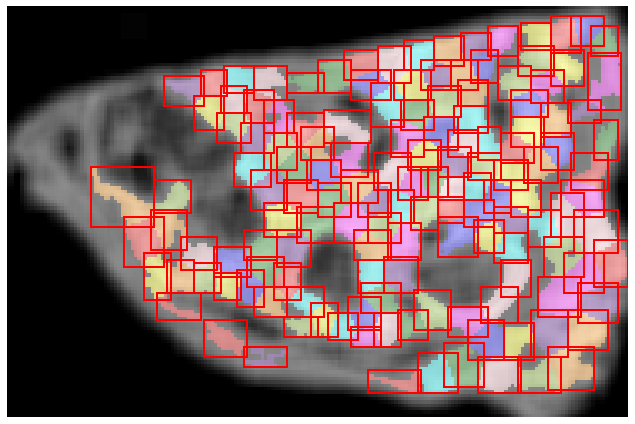

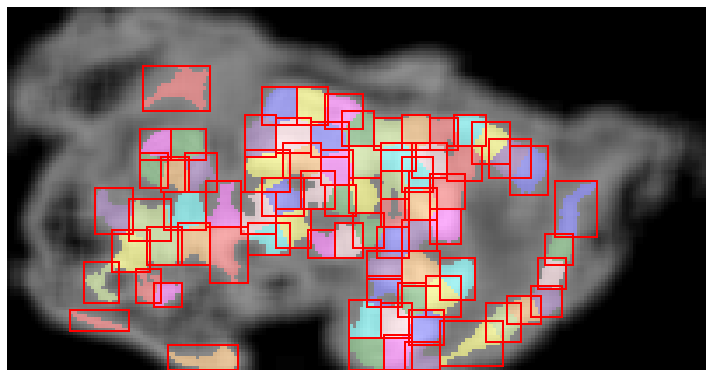

c:\Users\binli123\miniconda3\envs\pyg\lib\site-packages\scipy\cluster\vq.py:607: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


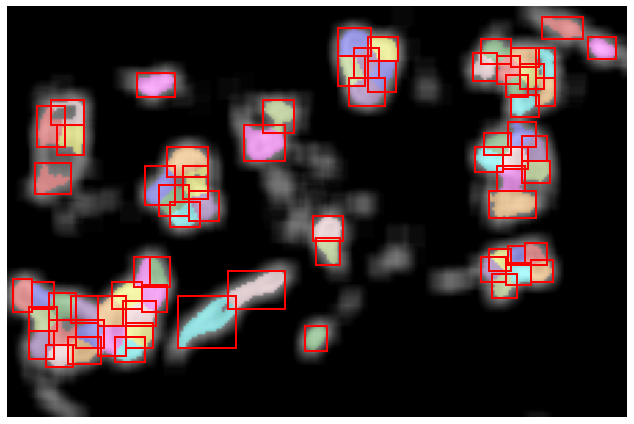

c:\Users\binli123\miniconda3\envs\pyg\lib\site-packages\scipy\cluster\vq.py:607: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


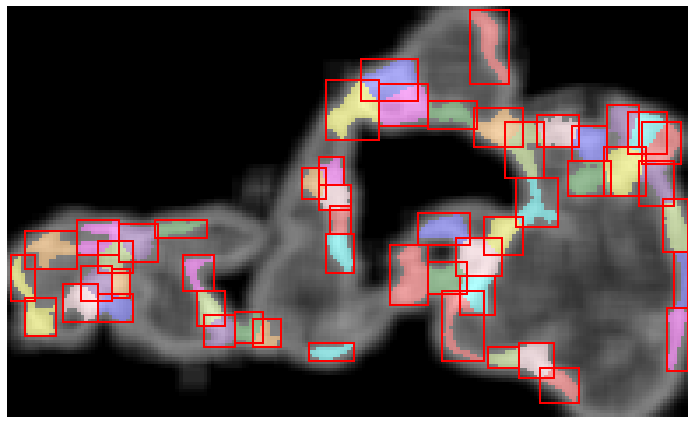

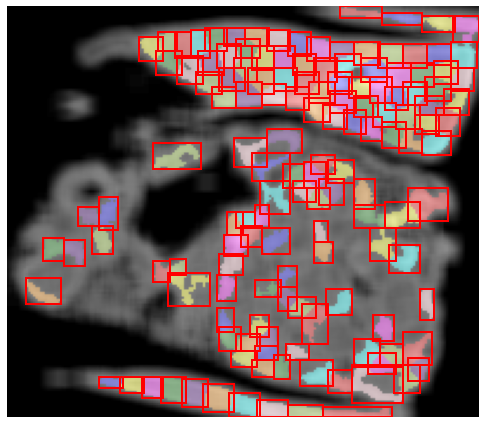

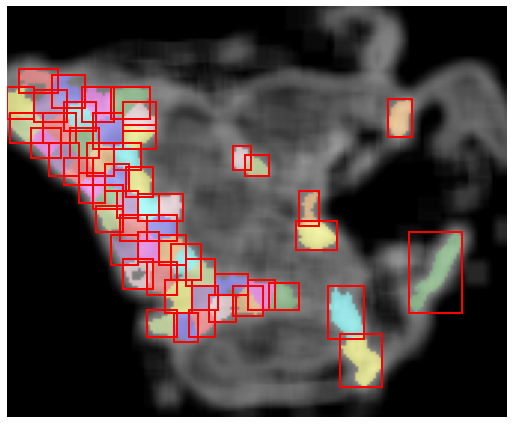

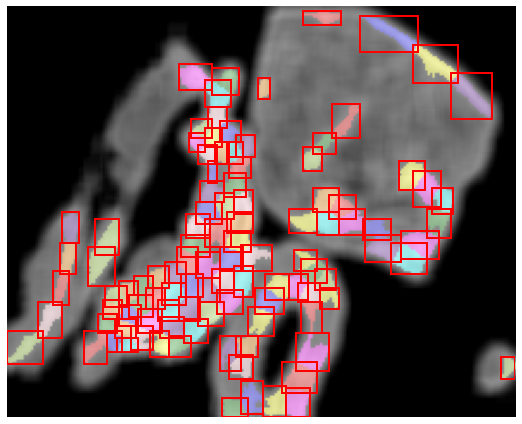

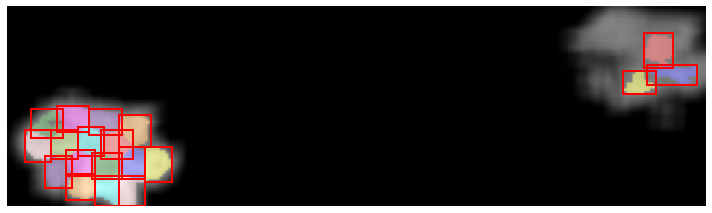

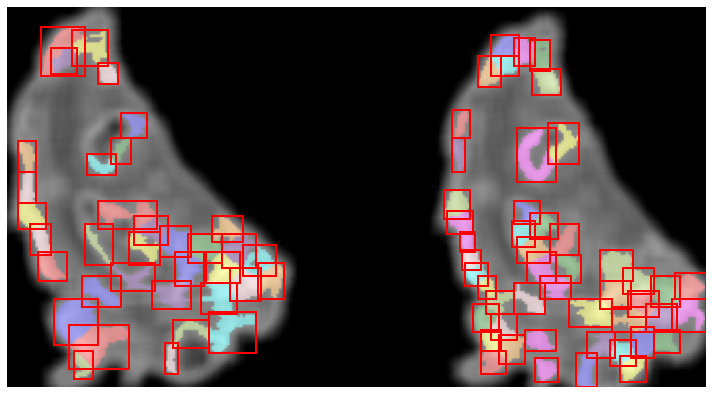

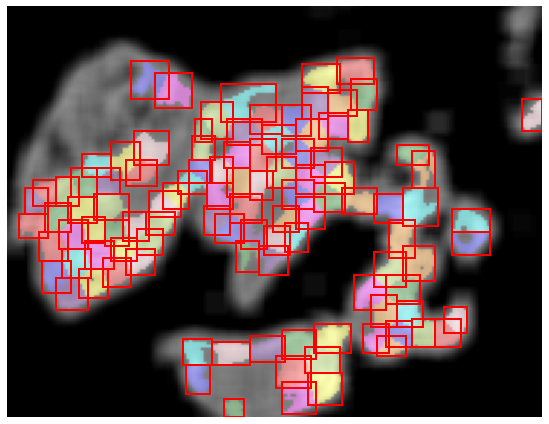

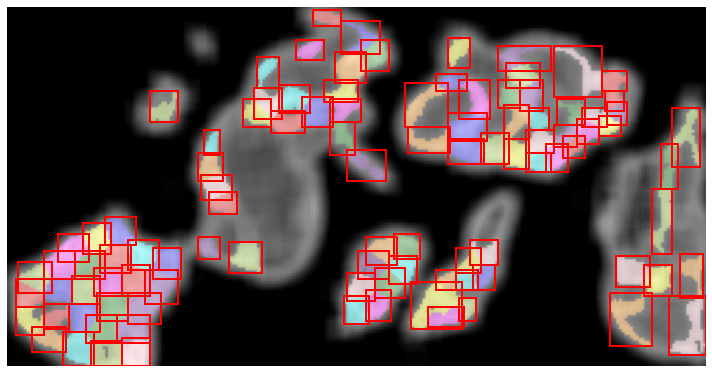

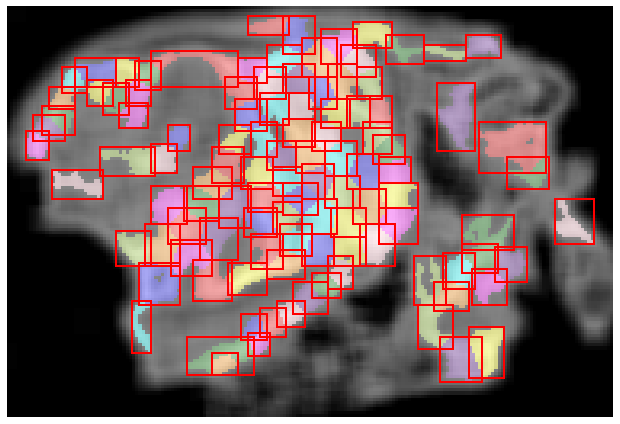

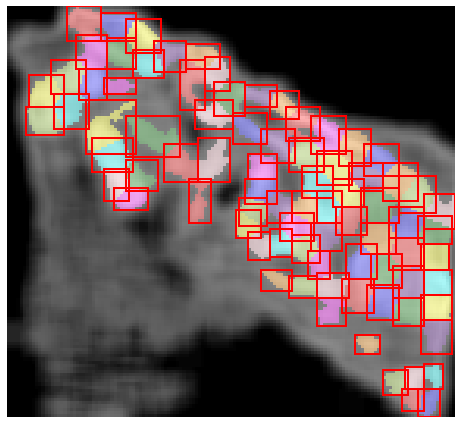

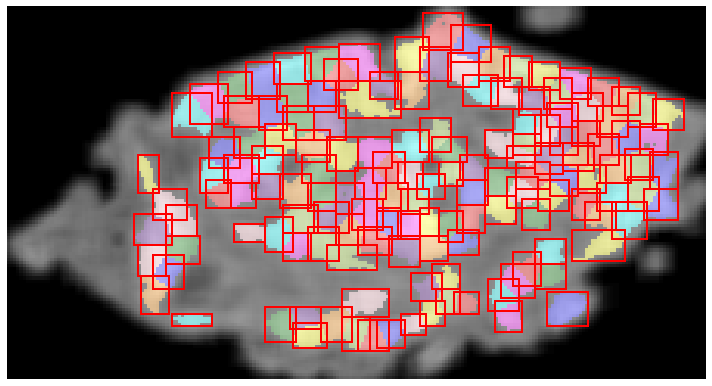

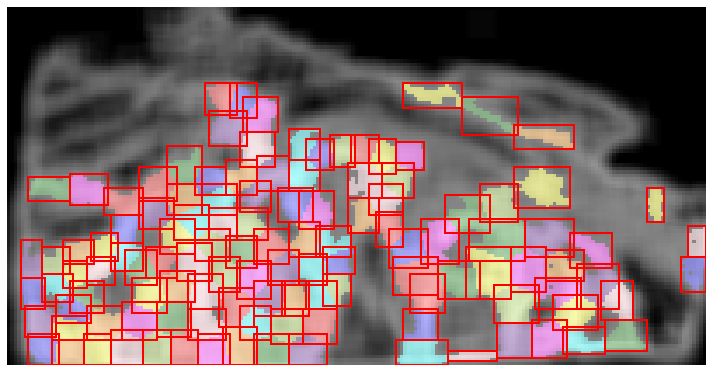

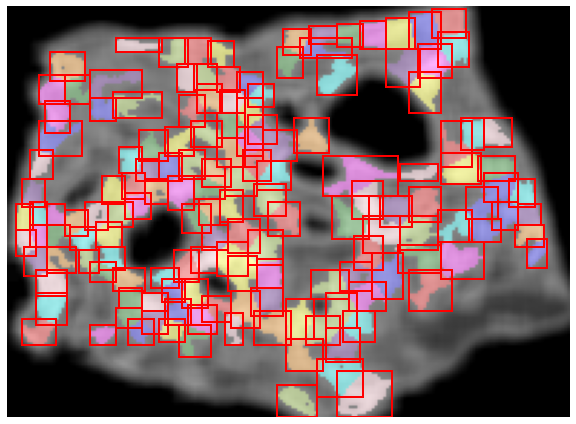

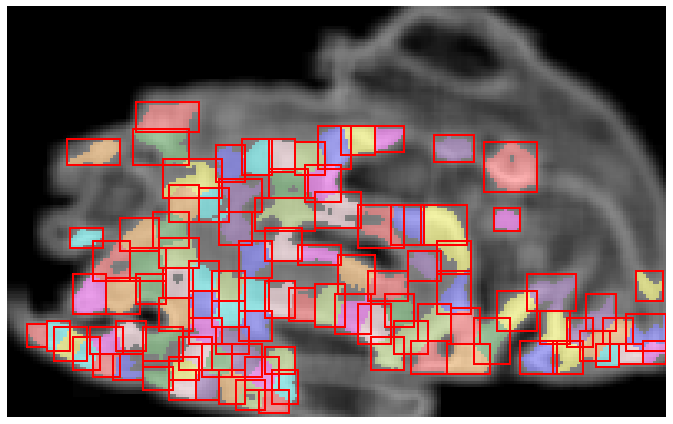

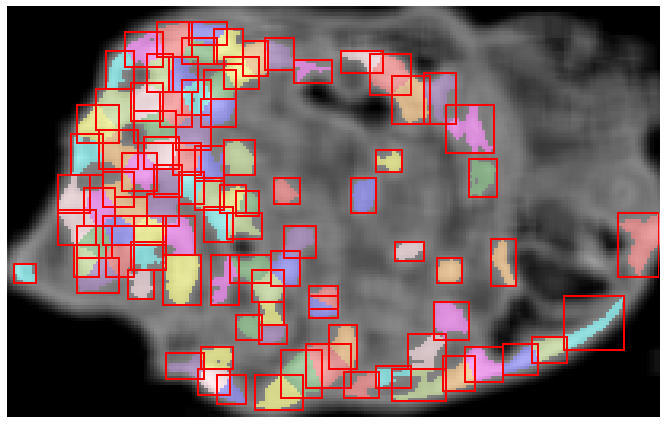

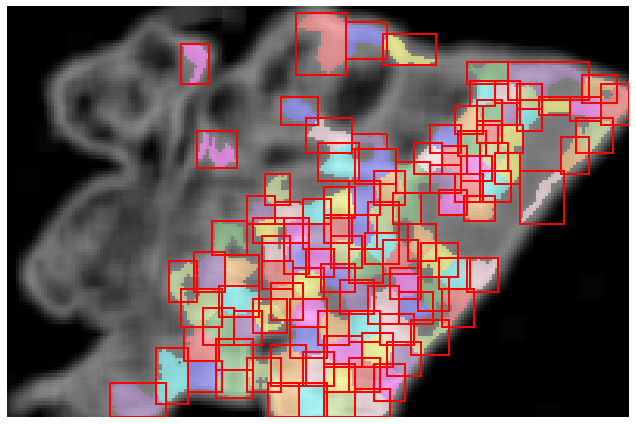

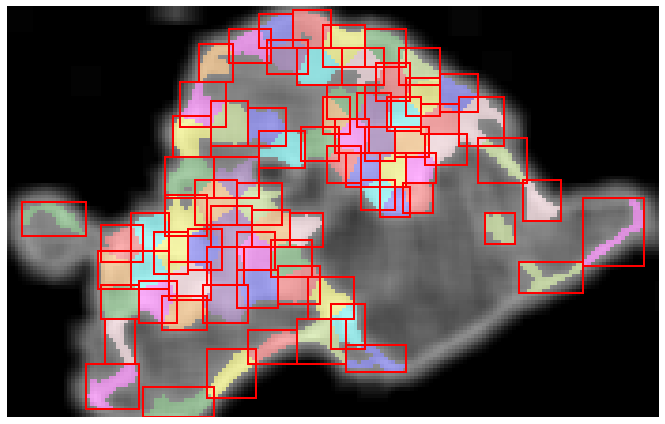

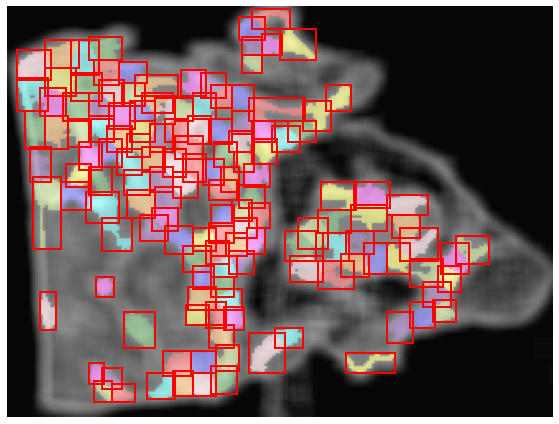

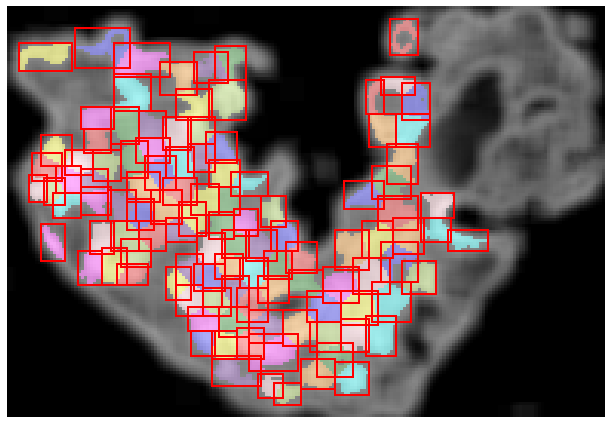

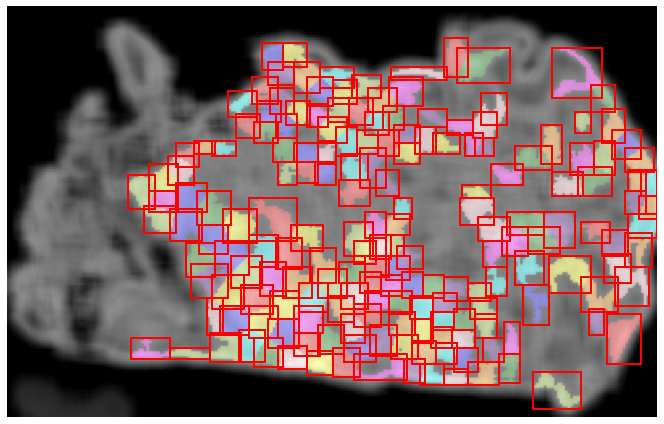

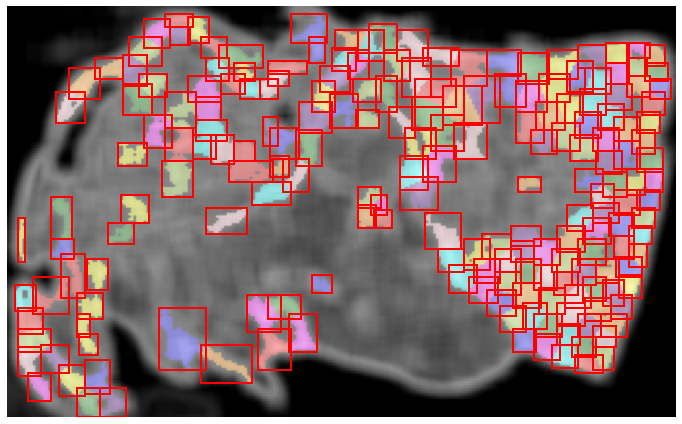

In [15]:
slide_bbox = []
stat_maps = []
reps_arr = []
for slide_rep in slides_reps:
    print_name = path.splitext(slide_rep)[0]+'.png'
    rep_arr = io.imread(slide_rep)
    ### if the slower method is used
    # stat_map = analysis_slide(rep_arr, query_stat=query_stats, clusterer=clusterer,
    #                             window_shape=window_shape, step_size=step_size, similarity='cosine', ana_method='kmeans', agg_method='mean')
    ### if the faster method is used
    stat_map = analysis_slide(rep_arr, clusterer=agg_clusterer, window_shape=window_shape, step_size=step_size, similarity='cosine', ana_method='mean', agg_method='kmeans')
    bbox_list = regions_slide(stat_map, radius=radius, thresh=thresh, percentile=percentile, print_box=True, print_name=print_name)
    slide_bbox.append(bbox_list)
    stat_maps.append(stat_map)
    reps_arr.append(rep_arr)
    io.imsave(path.join('stat_map', path.basename(slide_rep)), stat_map)